In [1]:
# Basic imports
import tweepy as tw
import pandas as pd     
import numpy as np 
import time
import os
import re

# Plotting and Visualization
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
%matplotlib inline

# TextBlob imports
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier

# NLTK Imports
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# info_apoio imports
from info_apoio import clean_tweet
from info_apoio import sentiment

# Autentificação

In [2]:
with open("C:\\Users\\leand\\OneDrive\\Documentos\\twitter_keys.txt", 'r') as tfile:
    consumer_key = tfile.readline().strip('\n')
    consumer_secret = tfile.readline().strip('\n')
    acces_token = tfile.readline().strip('\n')
    acces_token_secret = tfile.readline().strip('\n')        
    
    
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(acces_token, acces_token_secret)

api = tw.API(auth)

public_tweets = api.home_timeline()    


# Criando a base de dados


In [3]:
# Searchin Twitter Timelines
tweets = []
info = []
q1 = 'lula'
q2 = 'bolsonaro'
query = q1 + ' OR ' + q2 

for tweet in tw.Cursor(api.search_tweets,
                           q = query,
                           tweet_mode = 'extended',
                           # rpp=100,
                           result_type="popular",
                           # include_entities=True,
                           lang="pt").items(1000):
    if 'retweeted_status' in dir(tweet):
        aux=tweet.retweeted_status.full_text
    else:
        aux=tweet.full_text
        
    newtweet = aux.replace("\n", " ")
   
    tweets.append(newtweet)
    info.append(tweet)
    
    file = open("lula-bolsonaro.txt", "a", -1, "utf-8")
    file.write(newtweet+'\n')
    file.close()
    

In [4]:
#Construction of the dataframe
tweets_df = pd.DataFrame(tweets, columns=['Tweets']) 

tweets_df['len']  = np.array([len(tweet) for tweet in tweets])
tweets_df['ID']   = np.array([tweet.id for tweet in info])
tweets_df['Date'] = np.array([tweet.created_at for tweet in info])
tweets_df['Source'] = np.array([tweet.source for tweet in info])
tweets_df['Likes']  = np.array([tweet.favorite_count for tweet in info])
tweets_df['RTs']    = np.array([tweet.retweet_count for tweet in info])
tweets_df['User Location']    = np.array([tweet.user.location for tweet in info])
tweets_df['Geo']    = np.array([tweet.geo for tweet in info])
tweets_df['Coordinates']    = np.array([tweet.coordinates for tweet in info])

tweets_df.head(10)


,Tweets,len,ID,Date,Source,Likes,RTs,User Location,Geo,Coordinates
0,"Talvez a galera não tenha entendido, então vam...",186,1613883765440249857,2023-01-13 13:00:48+00:00,Twitter for iPhone,130258,19301,"Osasco, SP",None,None
1,"Para não ficar mais dúvidas, resumo do golpe n...",278,1613896850871820288,2023-01-13 13:52:48+00:00,Twitter Web App,45610,6178,,None,None
2,URGENTE! Mais uma prova que consegui para des...,223,1614021855660199955,2023-01-13 22:09:32+00:00,Twitter for iPhone,64556,16600,"Brasília, Brasil",None,None
3,"""Bora subir, gente, bora subir. Sou covarde nã...",292,1614052539900600321,2023-01-14 00:11:27+00:00,Twitter Web App,19183,3209,Brasil,None,None
4,Bolsonaro comprou mais de 3600 refeições😳 Sabe...,258,1614030803700449280,2023-01-13 22:45:05+00:00,Twitter for iPhone,20734,4784,,None,None
5,"Vitória de Lula foi roubada, diz Steve Bannon ...",69,1613889618637918208,2023-01-13 13:24:04+00:00,dlvr.it,24971,4644,Brasil,None,None
6,🚨BRASIL: O presidente Lula se reuniu com os tr...,158,1614000616614907923,2023-01-13 20:45:08+00:00,Twitter for iPhone,93213,5567,,None,None
7,🚨URGENTE: Polícia Federal encontra na casa de ...,191,1613608243145605125,2023-01-12 18:45:59+00:00,Twitter for iPhone,62772,5127,,None,None
8,O tipo de matéria que a esquerda ignora e que ...,247,1613925350207270914,2023-01-13 15:46:03+00:00,Twitter for iPhone,11810,3655,Niterói - Rio de Janeiro,None,None
9,"No dia 21 de janeiro de 2019, Jair Bolsonaro g...",278,1613683920532537348,2023-01-12 23:46:42+00:00,Twitter for iPhone,52693,7861,"São Paulo, Brasil",None,None


# Retweets e curtidas

In [5]:
# Top Searched Tweets
fav_max = np.max(tweets_df['Likes'])
rt_max  = np.max(tweets_df['RTs'])

fav = tweets_df[tweets_df.Likes == fav_max].index[0]
rt  = tweets_df[tweets_df.RTs == rt_max].index[0]

# Max FAVs:
print("O tweet com mais curtidas é: \n{}".format(tweets_df['Tweets'][fav]))
print("Número de curtidas: {}".format(fav_max))
print("\n")
# Max RTs:
print("O tweet com mais retweet é: \n{}".format(tweets_df['Tweets'][rt]))
print("Número de retweets: {}".format(rt_max))


O tweet com mais curtidas é: 
Decreto assinado por Lula para intervenção federal no Distrito Federal. #EquipeLula https://t.co/1gHjIuDGLf
Número de curtidas: 246443


O tweet com mais retweet é: 
Decreto assinado por Lula para intervenção federal no Distrito Federal. #EquipeLula https://t.co/1gHjIuDGLf
Número de retweets: 36537


# Fonte dos tweets

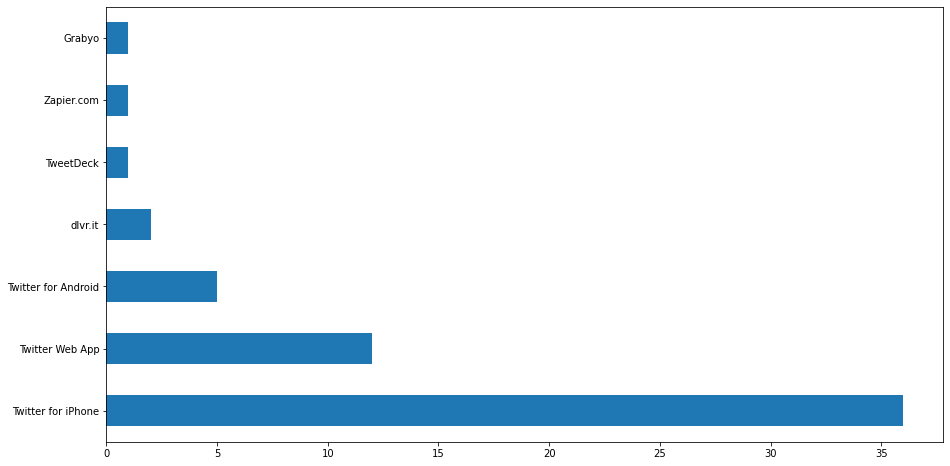

In [6]:
#Source of the Tweets
sources = []
for source in tweets_df['Source']:
    if source not in sources:
        sources.append(source)

percent = np.zeros(len(sources))

for source in tweets_df['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass
        
newDF = pd.DataFrame({
 'source':percent,
}, index=sources)


sources_sorted = newDF.sort_values('source',ascending=False)
ax = sources_sorted.source.plot(kind='barh', figsize=(15, 8))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))       

# Análise de sentimentos com TextBlob


In [7]:
#Sentiment Analysis in Português 

base_path = 'C:\\Users\\leand\\OneDrive\\Documentos\\nlp\\dados\\'
train = []
wordsPT = []
wordsPT_sentiments = []

files = [os.path.join(base_path, f) for f in os.listdir(base_path)]

for file in files:
    t = 1 if '_Positivos' in file else -1
    with open(file, 'r', encoding='utf-8', errors='ignore') as content_file:
        content = content_file.read()
        all = re.findall('\[.*?\]',content)
        for w in all:
            wordsPT.append((w[1:-1]))
            wordsPT_sentiments.append(t)
            train.append((w[1:-1], t))

cl = NaiveBayesClassifier(train)

In [8]:
tweets_df['SA TextBlob'] = np.array([sentiment(tweet, cl) for tweet in tweets_df['Tweets']]) #Portuguese Dictionary
tweets_df['SA TextBlob'].value_counts()

 1    53
-1     5
Name: SA TextBlob, dtype: int64

In [9]:
#Sentiment Analysis Results
pos_tweets = [tweet for index, tweet in enumerate(tweets_df['Tweets']) if tweets_df['SA TextBlob'][index] > 0]
neg_tweets = [tweet for index, tweet in enumerate(tweets_df['Tweets']) if tweets_df['SA TextBlob'][index] < 0]


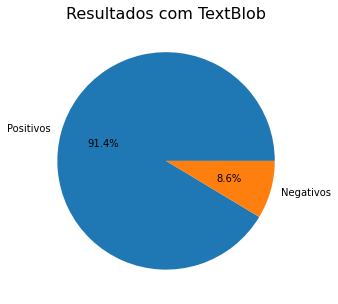

In [10]:
sentiments = ['Positivos', 'Negativos']
percents = [len(pos_tweets), len(neg_tweets)]

fig, ax = plt.subplots(figsize=(12, 5), facecolor='white')

ax.pie(percents, labels = sentiments, autopct='%.1f%%')
ax.set_title('Resultados com TextBlob', fontsize=16)

plt.show()


In [11]:
nltk.download('stopwords')
from nltk.corpus import stopwords

new_stopwords = stopwords.words('portuguese')

new_stopwords.append(q1)  # retirando a pesquisa inicial
new_stopwords.append(q2)

words = ' '.join(tweets_df['Tweets'])

words_clean = " ".join([word for word in words.split()
                            if 'https' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


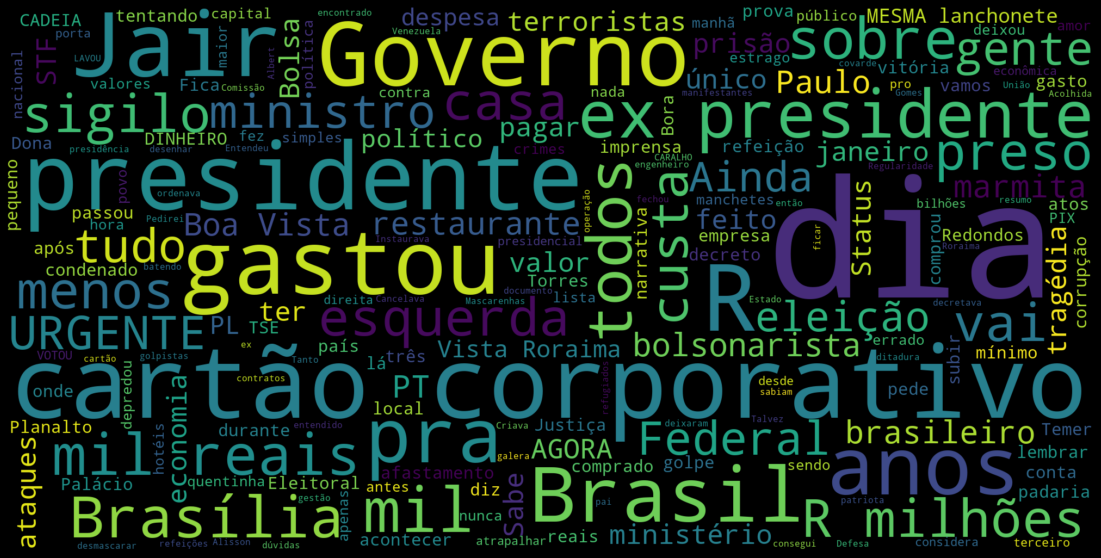

In [12]:
from imageio import imread
import warnings

warnings.simplefilter('ignore')

#twitter_mask = imread('brasil_mask.png')

wc = WordCloud(min_font_size=10, 
               max_font_size=300, 
               background_color='black', 
               mode="RGB",
               stopwords=new_stopwords,
               width=2000, 
               height=1000,
               #mask=twitter_mask,
               normalize_plurals= True).generate(words_clean)


fig, ax = plt.subplots(figsize=(20, 10), facecolor='black')

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('lula-bolsonaro.png', dpi=300)
plt.show()

# Análise de sentimentos com NLTK

In [13]:
vectorizer = CountVectorizer(analyzer="word")
freq_tweets = vectorizer.fit_transform(wordsPT)
modelo = MultinomialNB()
modelo.fit(freq_tweets, wordsPT_sentiments)

MultinomialNB()

In [14]:
tweetsarray = []

for tw in tweets_df['Tweets']:
    text = clean_tweet(tw)
    tweetsarray.append(text)

In [15]:
predictionData = vectorizer.transform(tweets_df['Tweets'])
tweets_df['SA NLTK'] = modelo.predict(predictionData)

In [16]:
#Sentiment Analysis Results
pos_tweets_nltk = [ tweet for index, tweet in enumerate(tweets_df['Tweets']) if tweets_df['SA NLTK'][index] > 0]
neg_tweets_nltk = [ tweet for index, tweet in enumerate(tweets_df['Tweets']) if tweets_df['SA NLTK'][index] < 0]


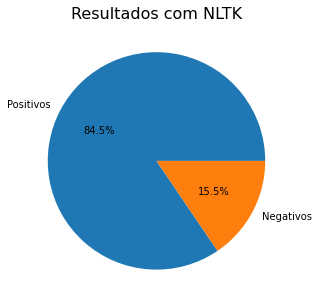

In [17]:
sentiments = ['Positivos', 'Negativos']
percents = [len(pos_tweets_nltk), len(neg_tweets_nltk)]

fig, ax = plt.subplots(figsize=(12, 5), facecolor='white')

ax.pie(percents, labels = sentiments, autopct='%.1f%%')
ax.set_title('Resultados com NLTK', fontsize=16)

plt.show()

In [18]:
words = ' '.join(tweets_df['Tweets'])

words_clean = " ".join([word for word in words.split()
                            if 'https' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])


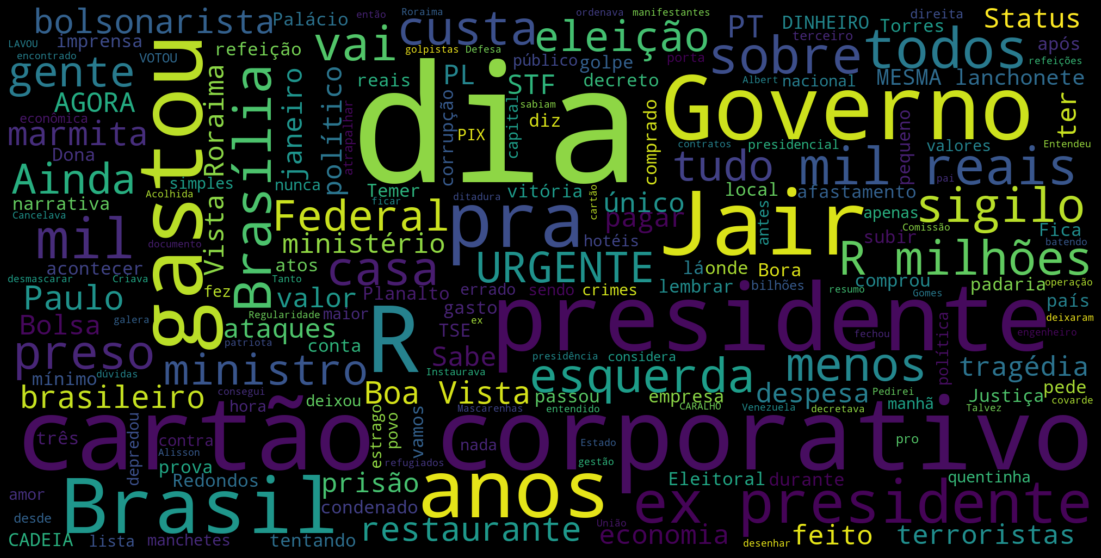

In [19]:
#twitter_mask = imread('brasil_mask.png')

wc = WordCloud(min_font_size=10, 
               max_font_size=300, 
               background_color='black', 
               mode="RGB",
               stopwords=new_stopwords,
               width=2000, 
               height=1000,
               #mask=twitter_mask,
               normalize_plurals= True).generate(words_clean)


fig, ax = plt.subplots(figsize=(20, 10), facecolor='black')

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('lula-bolsonaro.png', dpi=300)
plt.show()